# Notebook

Notebook para mostrar los pasos seguidos y los métodos y datos utilizados para la estimación de ....

__Bibliotecas utilizadas__

In [1]:
import os
import sys
import getpass
import bz2
import pickle # Rick!

import numpy as np
import pandas as pd
import math

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, ElasticNet

__Funciones auxiliares__

In [2]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Preprocesar los datos a utilizar

__Cargar los datos de matlab__

In [3]:
#df = loadmat("../../Data/Matlab/dB_ventana3.mat")
df = pd.read_csv("../../Data/csv/dB_eventos/dB_ventana3_5m.csv")

__Nombrar variables__
Para facilitar su uso

In [4]:
x_real=df.iloc[:,-2].to_numpy()
y_real=df.iloc[:,-1].to_numpy()

x_log = np.log(x_real)
y_log = np.log(y_real)

x_min=np.min(np.log(x_real))
x_max=np.max(np.log(x_real))

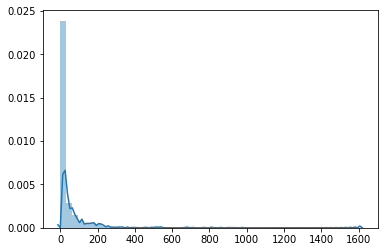

In [13]:
sns.distplot(y_real)

__Sacar medias para cada valor de duración__

In [5]:
data=[]
vals = np.unique(y_real)
for i in vals:
    pos = (i == y_real)
    data.append(np.mean(x_real[pos]))

## Relación entre variables RVR y duración de la niebla

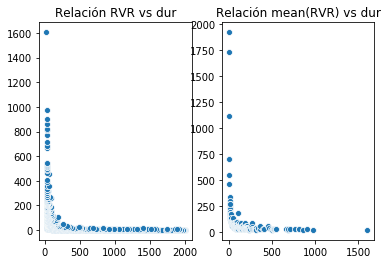

In [6]:
plt.subplot(1, 2, 1).set_title('Relación RVR vs dur')
sns.scatterplot(x=x_real,y=y_real)
plt.subplot(1, 2, 2).set_title('Relación mean(RVR) vs dur')
sns.scatterplot(x=vals, y=data)

Como tienen una distribución muy concreta y predecible, se podrían estimar los valores de duración a partir de la mínima visibilidad en el periodo. Se podría hacer un modelo de predicción estadística, que diera la media y stdev.

## Estimaciones

### Transformación Log-Log
Si se hace una transformación Log-Log de los datos, la estimación se podría hacer con modelo lineal (polinómico). Se visualiza una estimación polinómica de grado 2.

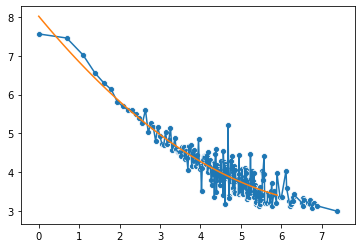

In [7]:
trend = np.polyfit(x=np.log(vals),y=np.log(data), deg=2)
trendpoly = np.poly1d(trend)
sns.lineplot(x=np.log(vals),y=np.log(data))
sns.scatterplot(x=np.log(vals),y=np.log(data))
sns.lineplot(np.arange(0,6,0.1),trendpoly(np.arange(0,6,0.1)))

### Estimación utilizando los valores medios de visibilidad para cada valor de duración

 Degree: 1 - RMSE: 0.3309468478281179
 Degree: 2 - RMSE: 0.2764037107274489
 Degree: 3 - RMSE: 0.2763531483321477
 Degree: 4 - RMSE: 0.274579180156262


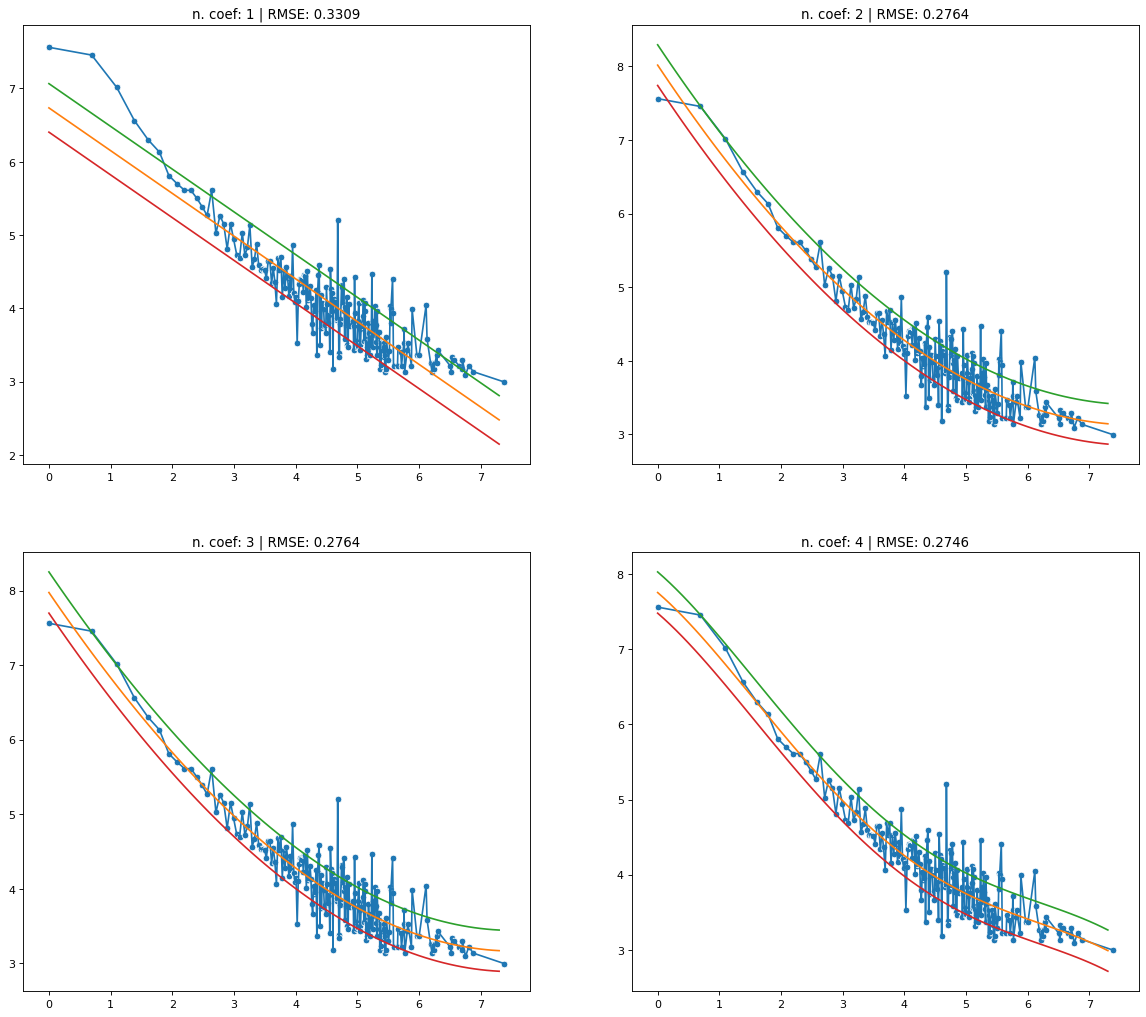

In [8]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

vals_min = np.min(np.log(vals))
vals_max = np.max(np.log(vals))

for i in range(1,5):
    trend = np.polyfit(x=np.log(vals),y=np.log(data), deg=i)
    trendpoly = np.poly1d(trend)
    # plt.plot(vals, data,'o')
    # plt.plot(trendpoly(vals), trendpoly(data), 'o')

    rmse = RMSE(trendpoly(np.log(vals)), np.log(data))
    
    plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse))
    sns.lineplot(x=np.log(vals),y=np.log(data))
    sns.scatterplot(x=np.log(vals),y=np.log(data))
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1)))
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1))+rmse)
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1))-rmse)
    print(" Degree: " + str(i) + " - RMSE: " + str(rmse))

### Estimación utilizando los valores  reales de visibilidad

 Degree: 1 - RMSE: 0.6911620297245034
 Degree: 2 - RMSE: 0.6437306673013679
 Degree: 3 - RMSE: 0.6322594742596754
 Degree: 4 - RMSE: 0.6307131597209964


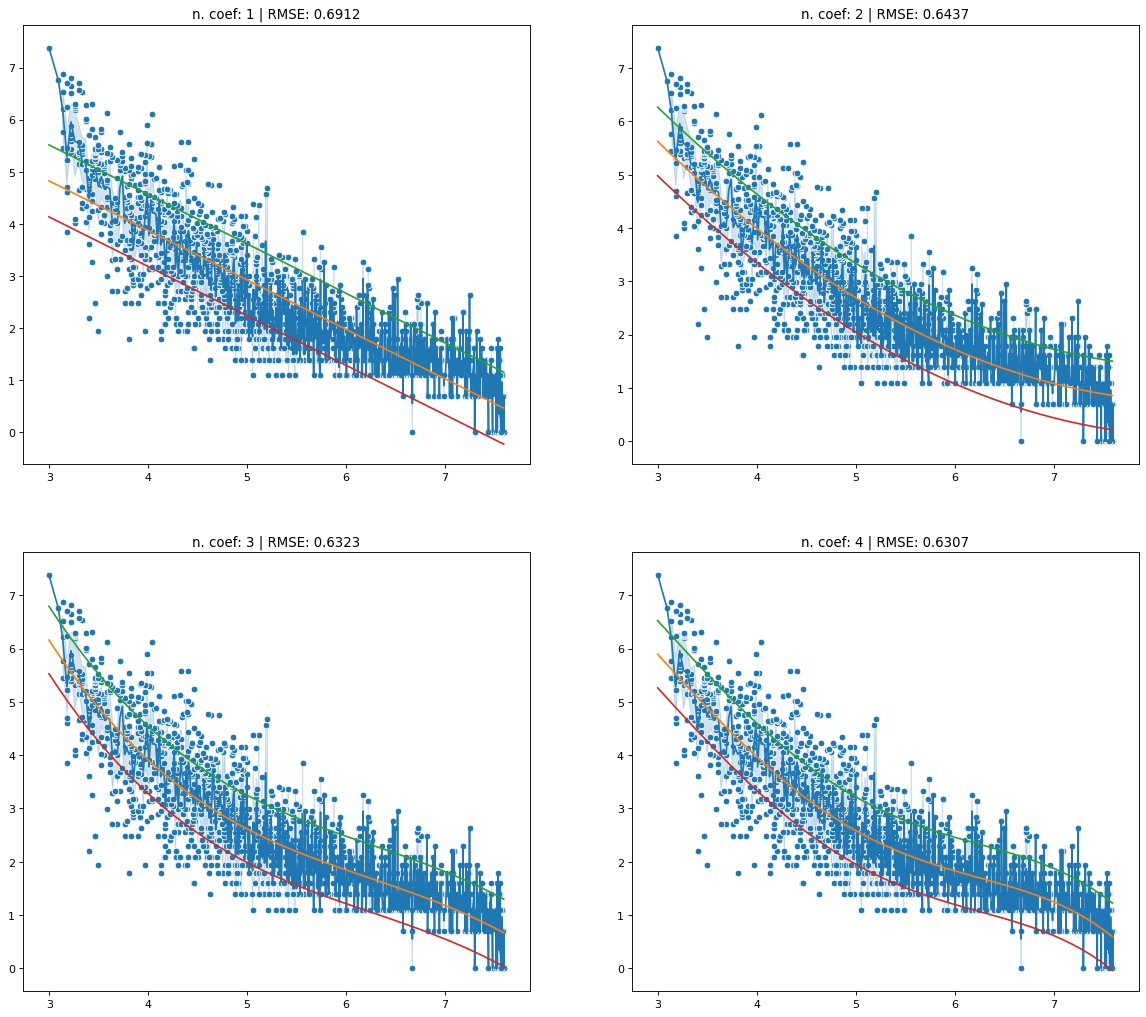

In [9]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

for i in range(1,5):
	trend = np.polyfit(x=np.log(x_real),y=np.log(y_real), deg=i)
	trendpoly = np.poly1d(trend)
	# plt.plot(x_real, y_real,'o')
	# plt.plot(trendpoly(x_real), trendpoly(y_real), 'o')

	rmse = RMSE(trendpoly(np.log(x_real)), np.log(y_real))

	plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse))
	sns.lineplot(x=np.log(x_real),y=np.log(y_real))
	sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
	sns.lineplot(x=np.arange(x_min,x_max,0.1),y=trendpoly(np.arange(x_min,x_max,0.1)))

	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) + rmse)
	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) - rmse)
	print(" Degree: " + str(i) + " - RMSE: " + str(rmse))


### Estimación utilizando los valores  reales de visibilidad con modelos con regularización (Not Done)

In [10]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

lm_ridge = Ridge()
lm_ridge.fit(X=x_log.reshape(-1, 1), y=y_log)
lm_ridge.coef_
lm_ridge.intercept_

lm_lasso = Lasso()
lm_lasso.fit(X=vals.reshape(-1, 1), y=data)
lm_lasso.coef_
lm_lasso.intercept_

lm_el_net = ElasticNet()
lm_el_net.fit(X=vals.reshape(-1, 1), y=data)
lm_el_net.coef_
lm_el_net.intercept_

131.18695649499716

### TODO:

* Sacar $\sigma$
* Hacer test $H_0$ de normalidad